In [1]:
from dotenv import load_dotenv
import json
import os
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated, TypedDict


MODEL = "mistral-nemo"
TEMPERATURE = 0
load_dotenv('.env', override=True)

"""
1. Define your State object
"""


class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    text: str
    claims: list[str]


LLM_OUTPUT_FORMAT = {
    "type": "array",
    "items": {
        "type": "string"
    }
}

llm = ChatOllama(
    model=MODEL,
    temperature=TEMPERATURE,
    format=LLM_OUTPUT_FORMAT
)

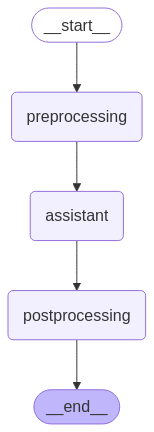

In [2]:
from IPython.display import Image, display

with open("prompts/claim_decomposer_system_prompt.txt", "r") as f:
    system_prompt = f.read()
system_message = SystemMessage(content=system_prompt)

def preprocessing(state: State) -> State:
    """
    Preprocesses state before sending to the assistant for decomposition.
    Currently, this just extracts the text from the state, and sets it
    as a HumanMessage following the SystemMessage
    """
    state['messages'] = [system_message, HumanMessage(content=state['text'])]
    return state

def assistant(state: State) -> State:
    """
    Gets the LLM response to System and Human prompt
    """
    print(f"Assistant node input:")
    for message in state['messages']:
        print(message)
    response = llm.invoke(state['messages'])
    print(f"Assistant node response:")
    print(response)
    return {'messages': response}

def postprocessing(state: State) -> State:
    """
    Postprocesses the LLM response to extract the claims
    Using format output on the LLM, we expect the AIMessage.content to be parsable
    as a list of strings
    """
    # We assume the last message in the state is the AI response
    message = state['messages'][-1]
    assert isinstance(message, AIMessage), "Expected the last message to be an AIMessage"
    # claims = message.content
    try:
        claims = json.loads(message.content)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from claim decomposer: {e}")

    return {'claims': claims}


builder = StateGraph(State)

# Define nodes
builder.add_node("preprocessing", preprocessing)
builder.add_node("assistant", assistant)
builder.add_node("postprocessing", postprocessing)

# Define edges
builder.add_edge(START, "preprocessing")
builder.add_edge("preprocessing", "assistant")
builder.add_edge("assistant", "postprocessing")
builder.add_edge("postprocessing", END)

claim_decomposer = builder.compile()


display(Image(claim_decomposer.get_graph(xray=True).draw_mermaid_png()))

In [3]:
text = """
The Apollo 11 mission landed humans on the Moon for the first time on July 20, 1969. 
Neil Armstrong was the first person to walk on the lunar surface.
The mission was launched by NASA using a Saturn V rocket.
"""

final_state = claim_decomposer.invoke({'text': text})

Assistant node input:
content='The user will give you some text. Your task is to identify and extract every factual claim made in the text.\n\n### Instructions:\n\nDefinition: A factual claim is any statement in the document that asserts a verifiable fact about the world (e.g., data points, events, or concrete information). Do not include opinions, subjective interpretations, or ambiguous statements.\n\nExtraction: Read the entire document carefully and list each individual factual claim. Each claim should be a complete statement that can be fact-checked.\n\nOutput Format:\n\nReturn your results as a JSON array of strings.\nEach string in the array must contain one factual claim.\nDo not include any additional text, explanations, or commentary—only the JSON array.\n\n### EXAMPLE:\nDocument:\n"Albert Einstein was born in Germany. He developed the theory of relativity, which revolutionized physics."\n\nOutput\n[\n  "Albert Einstein was born in Germany.",\n  "Albert Einstein developed the

In [4]:
for message in final_state['messages']:
    message.pretty_print()

================================ System Message ================================

The user will give you some text. Your task is to identify and extract every factual claim made in the text.

### Instructions:

Definition: A factual claim is any statement in the document that asserts a verifiable fact about the world (e.g., data points, events, or concrete information). Do not include opinions, subjective interpretations, or ambiguous statements.

Extraction: Read the entire document carefully and list each individual factual claim. Each claim should be a complete statement that can be fact-checked.

Output Format:

Return your results as a JSON array of strings.
Each string in the array must contain one factual claim.
Do not include any additional text, explanations, or commentary—only the JSON array.

### EXAMPLE:
Document:
"Albert Einstein was born in Germany. He developed the theory of relativity, which revolutionized physics."

Output
[
  "Albert Einstein was born in Germany.",
  

In [5]:
print(final_state['claims'])
print(type(final_state['claims']))

['The Apollo 11 mission landed humans on the Moon for the first time on July 20, 1969.', 'Neil Armstrong was the first person to walk on the lunar surface.', 'The mission was launched by NASA using a Saturn V rocket.']
<class 'list'>
